In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import os
import time
import math
import shutil
import soundfile as sf
import scipy.signal
from scipy.io import wavfile

import imageio
import librosa
import librosa.display
from IPython.display import Audio

torch.cuda.is_available()

False

## Display Graphs

#### display_graphs_bool

In [12]:
# Lists to store accuracy values for each epoch
metrics_train_accuracy = []
metrics_val_accuracy = []
metrics_train_loss = []
metrics_val_loss = []
metrics_epoch = []

def display_graphs(epoch, accuracy, val_accuracy, loss, val_loss, csv_dir):
    if isinstance(loss, torch.Tensor):
        loss = loss.cpu()

    loss = loss.detach().numpy()

    metrics_epoch.append(epoch+1)
    metrics_train_accuracy.append(accuracy)
    metrics_val_accuracy.append(val_accuracy)
    metrics_train_loss.append(loss)
    metrics_val_loss.append(val_loss)

    if (epoch+1) % interval == 0 or (epoch-1) == num_epochs:
        if epoch != 0:
            fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # Create a figure with two subplots
            axs[0].plot(metrics_epoch, metrics_train_accuracy, label='Training Accuracy', marker='o', markersize=4, color='#32a852')
            axs[0].plot(metrics_epoch, metrics_val_accuracy, label='Validation Accuracy', marker='o', markersize=4, color='#312af7')
            axs[0].set_xlabel('Epoch')
            axs[0].set_ylabel('Accuracy')
            axs[0].set_title('Training and Validation Accuracy')
            axs[0].set_ylim(acc_min_y, 1)
            axs[0].set_xlim(1, num_epochs)
            axs[0].legend()
            major_ticks = np.arange(0, num_epochs + 1, major_tick_spacing)
            minor_ticks = np.arange(0, num_epochs + 1, 1)
            axs[0].set_xticks(major_ticks)
            axs[0].set_xticks(minor_ticks, minor=True)
            axs[0].set_xticklabels(major_ticks.astype(int))
            axs[0].grid(True, which='both', linestyle='--', alpha=0.5)

            # Plot the loss graph in the second subplot
            axs[1].plot(metrics_epoch, metrics_train_loss, label='Training Loss', marker='o', markersize=4, color='#32a852')
            axs[1].plot(metrics_epoch, metrics_val_loss, label='Validation Loss', marker='o', markersize=4, color='#312af7')
            axs[1].set_xlabel('Epoch')
            axs[1].set_ylabel('Loss')
            axs[1].set_title('Training and Validation Loss')
            axs[1].set_ylim(loss_min_y, loss_max_y)
            axs[1].set_xlim(1, num_epochs)
            axs[1].legend()
            major_ticks = np.arange(0, num_epochs + 1, major_tick_spacing)
            minor_ticks = np.arange(0, num_epochs + 1, 1)
            axs[1].set_xticks(major_ticks)
            axs[1].set_xticks(minor_ticks, minor=True)
            axs[1].set_xticklabels(major_ticks.astype(int))
            axs[1].grid(True, which='both', linestyle='--', alpha=0.5)

            plt.tight_layout()
            plt.show()

            # Create a dictionary with your data
            data = {
                'Epoch': metrics_epoch,
                'Train Accuracy': metrics_train_accuracy,
                'Validation Accuracy': metrics_val_accuracy,
                'Train Loss': metrics_train_loss,
                'Validation Loss': metrics_val_loss
            }

            # Create a pandas DataFrame from your dictionary
            df = pd.DataFrame(data)
            # Save DataFrame to csv
            file_path = os.path.join(csv_dir, 'metrics.csv')
            df.to_csv(file_path, index=False)

#### display_graphs_zoomed_bool

In [13]:
# Lists to store accuracy values for each epoch
metrics_train_accuracy = []
metrics_val_accuracy = []
metrics_train_loss = []
metrics_val_loss = []
metrics_epoch = []

def display_graphs_zoomed(epoch, accuracy, val_accuracy, loss, val_loss):
    if isinstance(loss, torch.Tensor):
        loss = loss.cpu()

    loss = loss.detach().numpy()

    metrics_epoch.append(epoch+1)
    metrics_train_accuracy.append(accuracy)
    metrics_val_accuracy.append(val_accuracy)
    metrics_train_loss.append(loss)
    metrics_val_loss.append(val_loss)

    # calc y limit for accuracy
    if accuracy < val_accuracy:
        acc_y_lim = accuracy
    else:
        acc_y_lim = val_accuracy
    acc_y_lim = acc_y_lim - (acc_y_lim * 0.5)
    # TypeError: can't multiply sequence by non-int of type 'float'

    acc_y_lim = math.floor(acc_y_lim * 10) / 10

    # calc y limit for loss
    if loss > val_loss:
        val_y_lim = loss
    else:
        val_y_lim = val_loss

    if (epoch+1) % interval == 0 or (epoch-1) == num_epochs:
        if epoch != 0:
            fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # Create a figure with two subplots
            # Plot the accuracy graph in the first subplot
            axs[0].plot(metrics_epoch, metrics_train_accuracy, label='Training Accuracy', marker='o', markersize=4, color='#32a852')
            axs[0].plot(metrics_epoch, metrics_val_accuracy, label='Validation Accuracy', marker='o', markersize=4, color='#312af7')
            axs[0].set_xlabel('Epoch')
            axs[0].set_ylabel('Accuracy')
            axs[0].set_title('Training and Validation Accuracy')
            axs[0].set_ylim(acc_y_lim, 1)
            axs[0].set_xlim(1, num_epochs)
            axs[0].grid(True, linestyle='--', alpha=0.5)
            axs[0].legend()
            major_ticks = np.arange(0, num_epochs + 1, major_tick_spacing)
            minor_ticks = np.arange(0, num_epochs + 1, 1)
            axs[1].set_xticks(major_ticks)
            axs[1].set_xticks(minor_ticks, minor=True)
            axs[1].set_xticklabels(major_ticks.astype(int))
            axs[1].grid(True, which='both', linestyle='--', alpha=0.5)

            # Plot the loss graph in the second subplot
            axs[1].plot(metrics_epoch, metrics_train_loss, label='Training Loss', marker='o', markersize=4, color='#32a852')
            axs[1].plot(metrics_epoch, metrics_val_loss, label='Validation Loss', marker='o', markersize=4, color='#312af7')
            axs[1].set_xlabel('Epoch')
            axs[1].set_ylabel('Loss')
            axs[1].set_title('Training and Validation Loss')
            axs[1].set_ylim(0, val_y_lim)
            axs[1].set_xlim(1, num_epochs)
            axs[1].set_xticks(range(1, num_epochs + 1, major_tick_spacing))
            axs[1].grid(True, linestyle='--', alpha=0.5)
            axs[1].legend()
            major_ticks = np.arange(0, num_epochs + 1, 5)
            minor_ticks = np.arange(0, num_epochs + 1, 1)
            axs[1].set_xticks(major_ticks)
            axs[1].set_xticks(minor_ticks, minor=True)
            axs[1].set_xticklabels(major_ticks.astype(int))
            axs[1].grid(True, which='both', linestyle='--', alpha=0.5)

            plt.tight_layout()
            plt.show()

            # Create a dictionary with your data
            data = {
                'Epoch': metrics_epoch,
                'Train Accuracy': metrics_train_accuracy,
                'Validation Accuracy': metrics_val_accuracy,
                'Train Loss': metrics_train_loss,
                'Validation Loss': metrics_val_loss
            }

            # Create a pandas DataFrame from your dictionary
            df = pd.DataFrame(data)
            # Save DataFrame to csv
            file_path = os.path.join(csv_dir, 'metrics.csv')
            df.to_csv(file_path, index=False)

## Data

#### Play an example audio file

#### Display audio as mel spectogram

In [15]:
# Convert audio to a Mel spectrogram
y, sr = librosa.load(file_path)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)

# Display the Mel spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel',  cmap='cool')
plt.title('Mel spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
plt.show()

C:\Users\NUhunsere\AppData\Local\Temp\ipykernel_8964\2414622269.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path)
c:\Users\NUhunsere\miniconda3\envs\audio-env\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'Data\\Audio\\0\\0_george_0.wav'

#### Batch convert audio to mel spectogram

In [14]:
# Define the source and target directories
src_dir = r'My_Data\Audio'
target_dir = r'My_DataData\Mel'

# Loop over subdirectories 0-9
for i in range(10):
    src_subdir = os.path.join(src_dir, str(i))
    target_subdir = os.path.join(target_dir, str(i))

    # Create target subdirectory if it doesn't exist
    os.makedirs(target_subdir, exist_ok=True)

    # Get list of files in source subdirectory
    files = os.listdir(src_subdir)

    # Loop over files in source subdirectory with tqdm progress bar
    for file_name in tqdm(files, desc=f'Processing files in directory {i}'):
        src_file_path = os.path.join(src_subdir, file_name)
        target_file_path = os.path.join(target_subdir, file_name.replace('.wav', '.png'))

        # Convert audio to a Mel spectrogram
        y, sr = librosa.load(src_file_path, sr=16000)  # Specify the sampling rate here
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        log_S = librosa.power_to_db(S, ref=np.max)

        # Normalize to [0, 255] and convert to uint8
        img = ((log_S - log_S.min()) / (log_S.max() - log_S.min()) * 255).astype(np.uint8)

        # Save the Mel spectrogram as a PNG image
        imageio.imwrite(target_file_path, img)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Data\\Audio\\0'

## Model

In [16]:
# Load the pretrained model
model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')

# If you want to do finetuning then set requires_grad = False
# This will freeze the weights for all layers
for param in model.parameters():
    param.requires_grad = False

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Replace the last layer for 10 classes
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 10),
    nn.Sigmoid()
)

In [17]:
print(type(model))

<class 'torchvision.models.resnet.ResNet'>


#### Define parameters

In [18]:
batch_size = 16
num_epochs = 300
image_size = (16, 128)
learning_rate = 0.001
use_scheduler = True

display_graphs_bool = True
acc_min_y = 0.8
loss_max_y = 2
loss_min_y = 1
major_tick_spacing = 20
display_graphs_zoomed_bool = False
interval = 100
debug = False

In [20]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
if use_scheduler:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.9)

#### Preprocess Data

In [23]:
data_dir = r"C:\Users\NUhunsere\fine_tuning_project\My_Data\Mel_Specs"

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

# Load the data
full_dataset = ImageFolder(data_dir, transform=transform)

# Split the data into training and test sets
train_size = int(0.8 * len(full_dataset))  # 80% for training
test_size = len(full_dataset) - train_size  # 20% for testing
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Dataloaders
batch_size = 16
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

print(len(test_dataset))
print(len(train_dataset))


print(f"Moving model to device...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check if GPU is available
print(f"Device count: {device}")
model.to(device)  # Move the model to the device (CPU or GPU)
print("Complete")

print("Setting up model...")
model.train()  # Set the model to training mode

loss_function = nn.CrossEntropyLoss()  # Define the loss function
model.zero_grad()  # Reset gradients tensors
optimizer.zero_grad()  # Reset optimizer gradients
print("Complete")

total_steps = len(train_loader)  # Total number of steps in an epoch

600
2400
Moving model to device...
Device count: cpu
Complete
Setting up model...
Complete


#### Save callback

In [24]:
checkpoint_dir = "ModelSaves\M2"
model_name = "M2"
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(epoch, model, optimizer, loss, val_loss, accuracy, val_accuracy):
    checkpoint_path = os.path.join(checkpoint_dir, f'{model_name}_epoch_{epoch+1}_loss_{loss:.4f}_vloss{val_loss:.4f}_acc_{accuracy:.4f}_vacc{val_accuracy:.4f}.pt')
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, checkpoint_path)

def save_model(epoch, model, optimizer, loss, val_loss, accuracy, val_accuracy):
    path = os.path.join(checkpoint_dir, f'{model_name}_epoch_{epoch+1}_loss_{loss:.4f}_vloss{val_loss:.4f}_acc_{accuracy:.4f}_vacc{val_accuracy:.4f}.pt')
    torch.save(model, path)

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\NUhunsere\AppData\Local\Temp\ipykernel_8964\3868313646.py:1: SyntaxWarning: invalid escape sequence '\M'
  checkpoint_dir = "ModelSaves\M2"


#### Training

Beginning training...
Epoch [1/300], Loss: 1.8228, Acc: 0.4108, Val Loss: 1.9090, Val Acc: 0.6250
Epoch [2/300], Loss: 1.7638, Acc: 0.6783, Val Loss: 1.8435, Val Acc: 0.6639
Epoch [3/300], Loss: 1.7468, Acc: 0.7533, Val Loss: 1.8234, Val Acc: 0.6639
Epoch [4/300], Loss: 1.6596, Acc: 0.7871, Val Loss: 1.7603, Val Acc: 0.6926
Epoch [5/300], Loss: 1.6621, Acc: 0.8229, Val Loss: 1.7160, Val Acc: 0.7601
Epoch [6/300], Loss: 1.6422, Acc: 0.8404, Val Loss: 1.6652, Val Acc: 0.8176
Epoch [7/300], Loss: 1.6972, Acc: 0.8375, Val Loss: 1.7662, Val Acc: 0.7027
Epoch [8/300], Loss: 1.6361, Acc: 0.8358, Val Loss: 1.6892, Val Acc: 0.8024
Epoch [9/300], Loss: 1.6243, Acc: 0.8671, Val Loss: 1.6301, Val Acc: 0.8480
Epoch [10/300], Loss: 1.7096, Acc: 0.8654, Val Loss: 1.6497, Val Acc: 0.8446
Epoch [11/300], Loss: 1.6096, Acc: 0.8833, Val Loss: 1.6263, Val Acc: 0.8514
Epoch [12/300], Loss: 1.5940, Acc: 0.8762, Val Loss: 1.5959, Val Acc: 0.8902
Epoch [13/300], Loss: 1.5693, Acc: 0.8783, Val Loss: 1.5988, Va

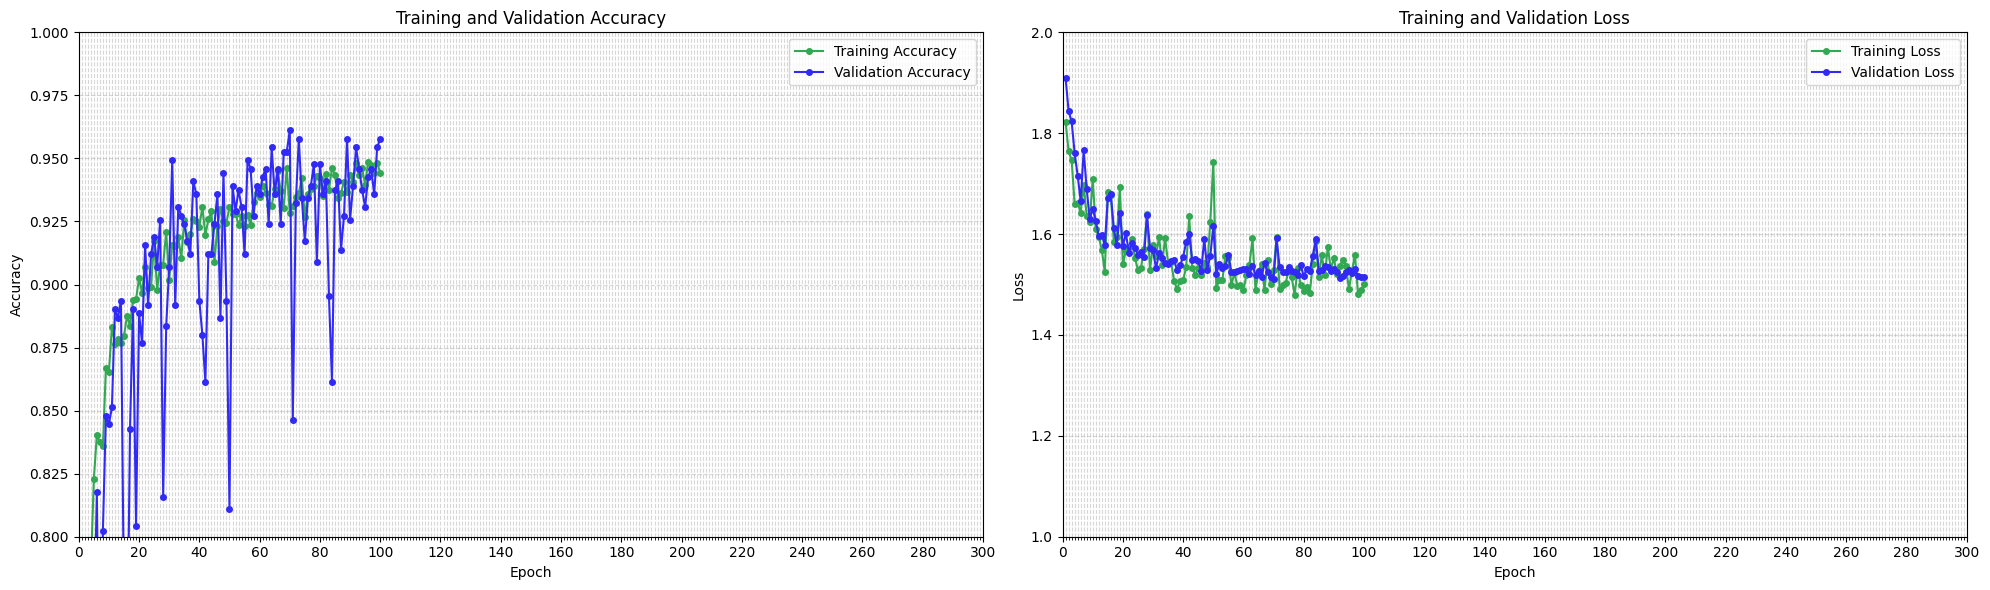

Epoch [101/300], Loss: 1.4883, Acc: 0.9446, Val Loss: 1.5125, Val Acc: 0.9561
Epoch [102/300], Loss: 1.4899, Acc: 0.9325, Val Loss: 1.5123, Val Acc: 0.9476
Epoch [103/300], Loss: 1.5228, Acc: 0.9454, Val Loss: 1.5167, Val Acc: 0.9443
Epoch [104/300], Loss: 1.5011, Acc: 0.9458, Val Loss: 1.5241, Val Acc: 0.9493
Epoch [105/300], Loss: 1.5071, Acc: 0.9467, Val Loss: 1.5212, Val Acc: 0.9358
Epoch [106/300], Loss: 1.4962, Acc: 0.9467, Val Loss: 1.5132, Val Acc: 0.9628
Epoch [107/300], Loss: 1.4996, Acc: 0.9437, Val Loss: 1.5295, Val Acc: 0.9274
Epoch [108/300], Loss: 1.4939, Acc: 0.9492, Val Loss: 1.5148, Val Acc: 0.9544
Epoch [109/300], Loss: 1.4883, Acc: 0.9467, Val Loss: 1.5104, Val Acc: 0.9544
Epoch [110/300], Loss: 1.4853, Acc: 0.9454, Val Loss: 1.5102, Val Acc: 0.9544
Epoch [111/300], Loss: 1.5096, Acc: 0.9467, Val Loss: 1.5234, Val Acc: 0.9426
Epoch [112/300], Loss: 1.5384, Acc: 0.9479, Val Loss: 1.5197, Val Acc: 0.9324
Epoch [113/300], Loss: 1.5326, Acc: 0.9521, Val Loss: 1.5522, Va

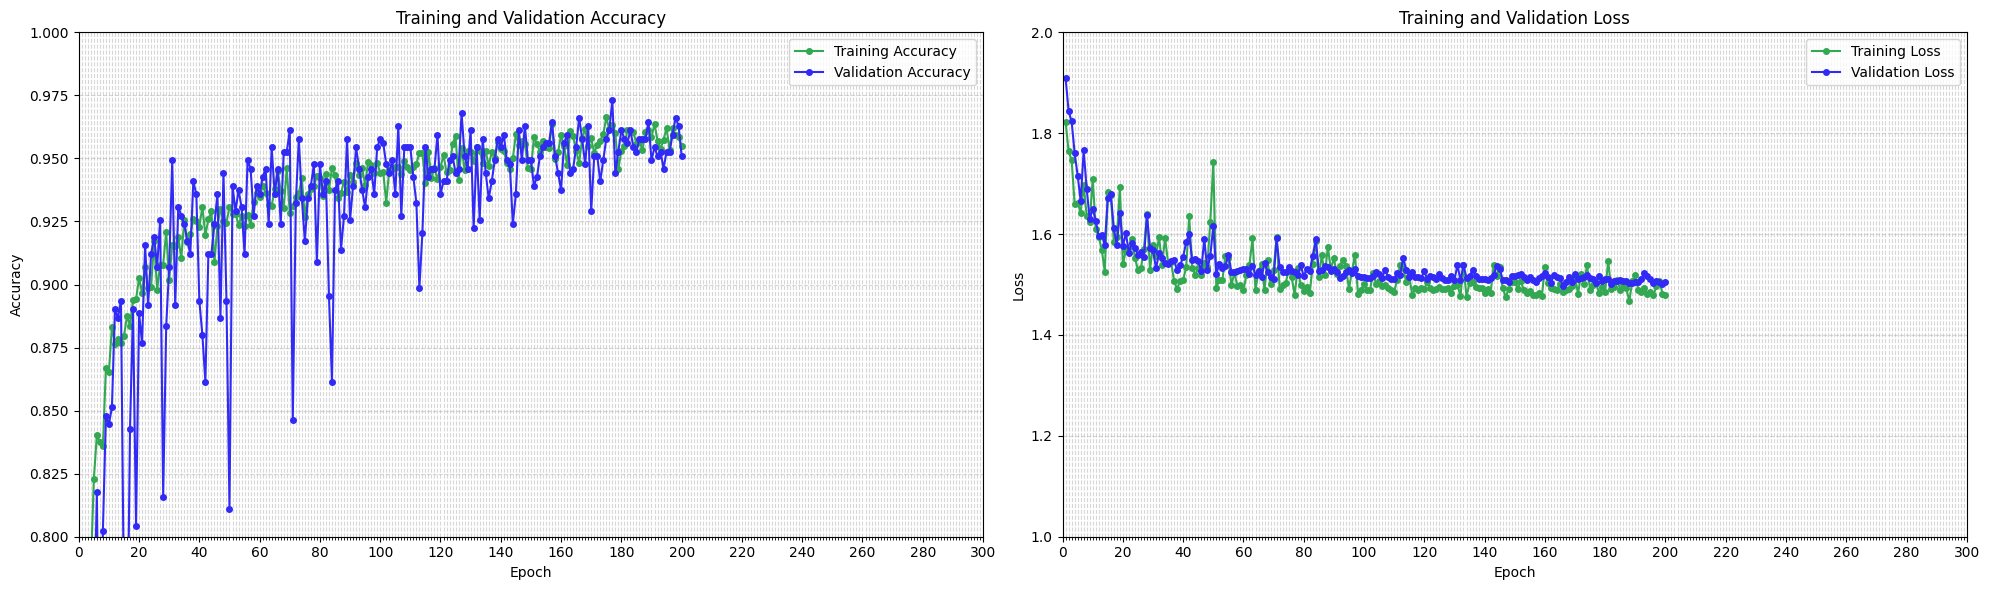

Epoch [201/300], Loss: 1.4742, Acc: 0.9633, Val Loss: 1.5005, Val Acc: 0.9611
Epoch [202/300], Loss: 1.4847, Acc: 0.9617, Val Loss: 1.5051, Val Acc: 0.9679
Epoch [203/300], Loss: 1.4737, Acc: 0.9475, Val Loss: 1.5025, Val Acc: 0.9713
Epoch [204/300], Loss: 1.5283, Acc: 0.9550, Val Loss: 1.5094, Val Acc: 0.9645
Epoch [205/300], Loss: 1.4980, Acc: 0.9608, Val Loss: 1.5245, Val Acc: 0.9375
Epoch [206/300], Loss: 1.4966, Acc: 0.9521, Val Loss: 1.5047, Val Acc: 0.9578
Epoch [207/300], Loss: 1.5031, Acc: 0.9629, Val Loss: 1.5041, Val Acc: 0.9595
Epoch [208/300], Loss: 1.4917, Acc: 0.9550, Val Loss: 1.5070, Val Acc: 0.9510
Epoch [209/300], Loss: 1.4826, Acc: 0.9596, Val Loss: 1.5068, Val Acc: 0.9679
Epoch [210/300], Loss: 1.4812, Acc: 0.9525, Val Loss: 1.5098, Val Acc: 0.9459
Epoch [211/300], Loss: 1.4820, Acc: 0.9688, Val Loss: 1.4962, Val Acc: 0.9662
Epoch [212/300], Loss: 1.5018, Acc: 0.9642, Val Loss: 1.5007, Val Acc: 0.9662
Epoch [213/300], Loss: 1.4783, Acc: 0.9579, Val Loss: 1.5030, Va

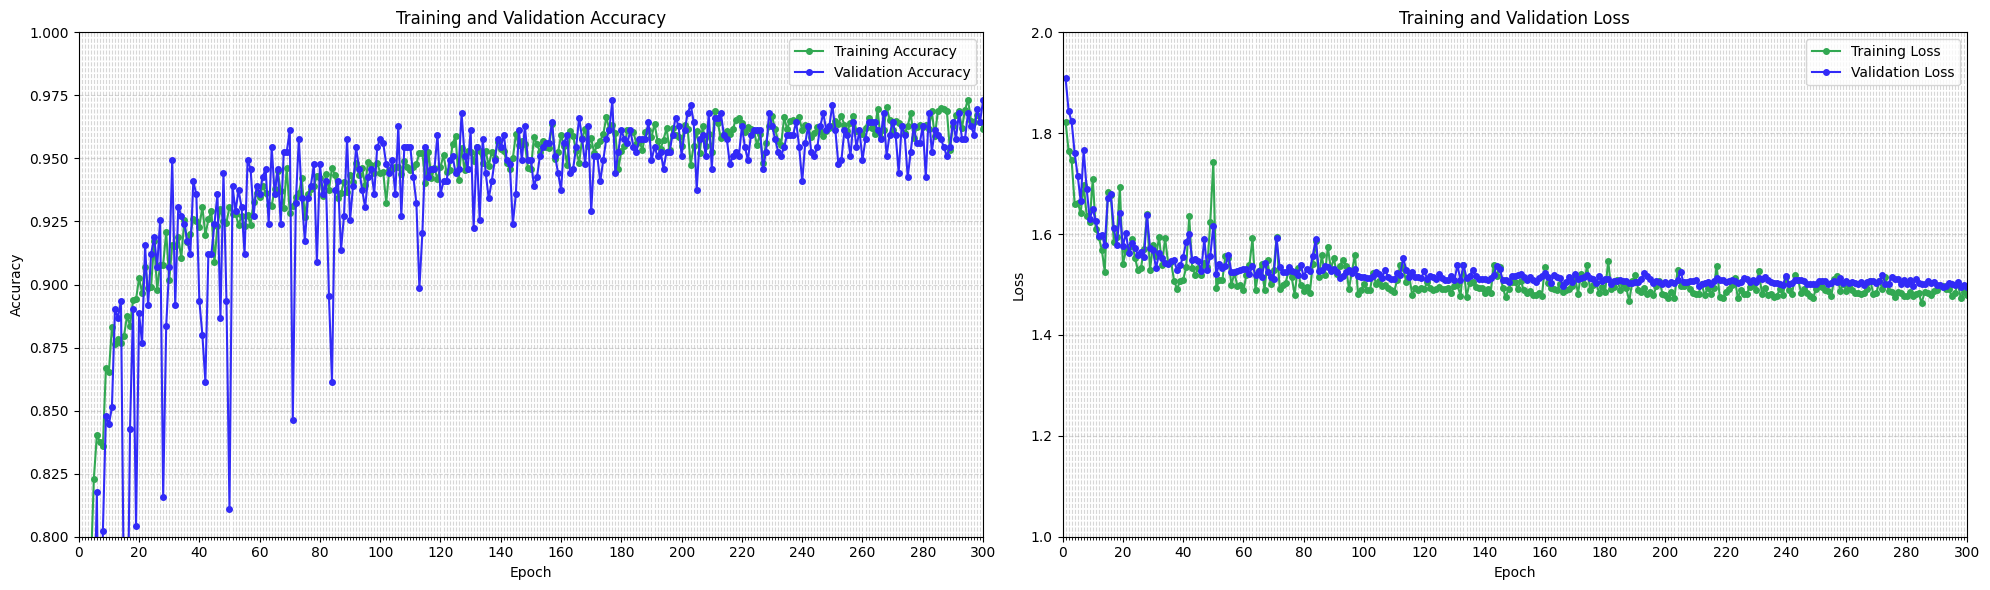

In [25]:
show_progress_bar = False

print("Beginning training...")
for epoch in range(num_epochs):
  if show_progress_bar:
    progress_bar = tqdm(train_loader, total=total_steps, leave=True)
  else:
    progress_bar = train_loader
  total_correct = 0
  total_samples = 0
  for i, (inputs, labels) in enumerate(progress_bar):
    inputs = inputs.to(device)
    labels = labels.to(device)
    predictions = model(inputs)
    if debug == True:
      print('*** DEBUG ***')
      print('Predictions: ', predictions.shape)
      print('Labels: ', labels.shape)
      print('Inputs: ', inputs.shape)
      print()

    loss = loss_function(predictions, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, predicted_labels = torch.max(predictions, 1)
    total_correct += (predicted_labels == labels).sum().item()
    total_samples += labels.size(0)

  if show_progress_bar:
    progress_bar.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
    progress_bar.set_postfix(loss=loss.item())

  model.eval()
  with torch.no_grad():
    val_loss = 0
    val_correct = 0
    val_samples = 0
    for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      predictions = model(inputs)
      loss = loss_function(predictions, labels)

      _, predicted_labels = torch.max(predictions, 1)
      val_correct += (predicted_labels == labels).sum().item()
      val_samples += labels.size(0)
      val_loss += loss.item()

    val_loss /= len(test_loader)
    val_accuracy = val_correct / val_samples
    accuracy = total_correct / total_samples

    if use_scheduler:
      scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}, Acc: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

  if display_graphs_bool == True:
    display_graphs(epoch, accuracy, val_accuracy, loss, val_loss, checkpoint_dir)
  if display_graphs_zoomed_bool == True:
    display_graphs_zoomed(epoch, accuracy, val_accuracy, loss, val_loss, checkpoint_dir)

  save_checkpoint(epoch, model, optimizer, loss, val_loss, accuracy, val_accuracy)
  save_model(epoch, model, optimizer, loss, val_loss, accuracy, val_accuracy)

  model.train()

Highest validation accuracy: 0.9695945945945946 at epoch: 271


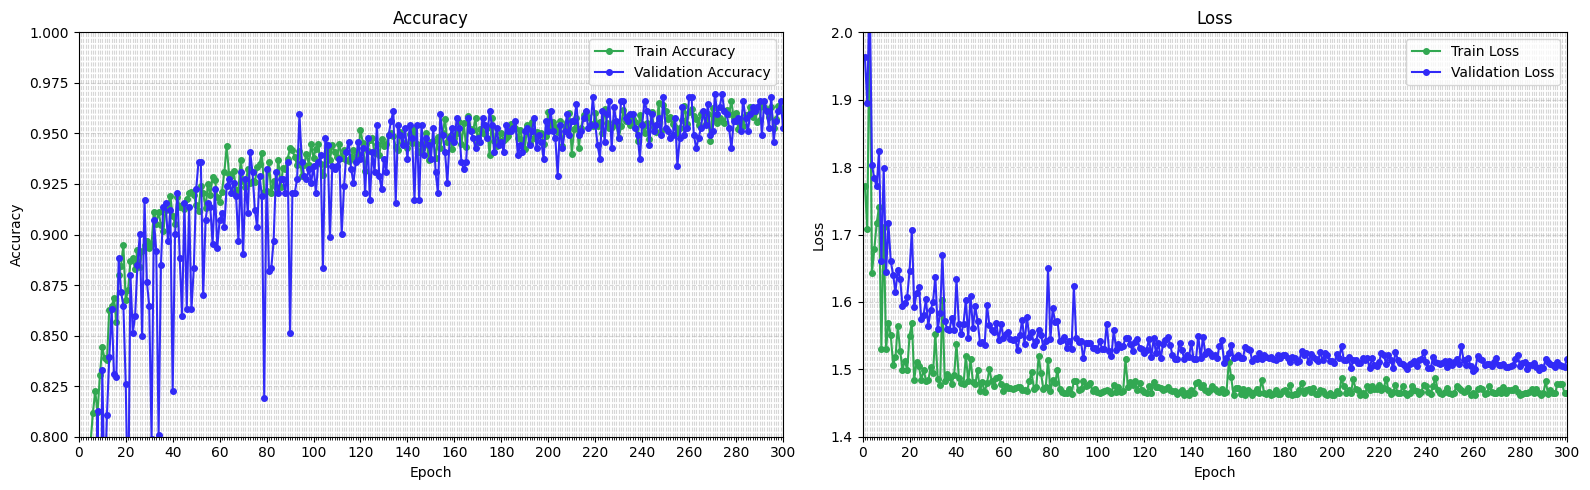

In [ ]:
df = pd.read_csv(r'ModelSaves\M2\metrics.csv')

# Find the maximum validation accuracy and the corresponding epoch
max_val_accuracy = df['Validation Accuracy'].max()
max_val_epoch = df[df['Validation Accuracy'] == max_val_accuracy]['Epoch'].values[0]
print(f'Highest validation accuracy: {max_val_accuracy} at epoch: {max_val_epoch}')

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot the accuracy
axs[0].plot(df['Epoch'], df['Train Accuracy'], label='Train Accuracy', marker='o', markersize=4, color='#32a852')
axs[0].plot(df['Epoch'], df['Validation Accuracy'], label='Validation Accuracy', marker='o', markersize=4, color='#312af7')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy')
axs[0].set_ylim(acc_min_y, 1)
axs[0].set_xlim(1, num_epochs)
axs[0].legend()
major_ticks = np.arange(0, num_epochs + 1, major_tick_spacing)
minor_ticks = np.arange(0, num_epochs + 1, 1)
axs[0].set_xticks(major_ticks)
axs[0].set_xticks(minor_ticks, minor=True)
axs[0].set_xticklabels(major_ticks.astype(int))
axs[0].grid(True, which='both', linestyle='--', alpha=0.5)

# Plot the loss
axs[1].plot(df['Epoch'], df['Train Loss'], label='Train Loss', marker='o', markersize=4, color='#32a852')
axs[1].plot(df['Epoch'], df['Validation Loss'], label='Validation Loss', marker='o', markersize=4, color='#312af7')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss')
axs[1].set_ylim(1.4, 2)
axs[1].set_xlim(1, num_epochs)
axs[1].legend()
major_ticks = np.arange(0, num_epochs + 1, major_tick_spacing)
minor_ticks = np.arange(0, num_epochs + 1, 1)
axs[1].set_xticks(major_ticks)
axs[1].set_xticks(minor_ticks, minor=True)
axs[1].set_xticklabels(major_ticks.astype(int))
axs[1].grid(True, which='both', linestyle='--', alpha=0.5)

# Show the plots
plt.tight_layout()
plt.show()


## Test Model

In [27]:
path = r'C:\Users\NUhunsere\fine_tuning_project\ModelSaves\M2\M2_epoch_300_loss_1.4795_vloss1.4949_acc_0.9617_vacc0.9730.pt'

model = torch.load(path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

C:\Users\NUhunsere\AppData\Local\Temp\ipykernel_8964\2599374977.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
from sklearn.metrics import classification_report

true_labels = []
pred_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs) 
        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.numpy().tolist())
        pred_labels.extend(preds.cpu().numpy().tolist())

report = classification_report(true_labels, pred_labels, output_dict=True)

print(f'Precision: {report["macro avg"]["precision"]}')
print(f'Recall: {report["macro avg"]["recall"]}')
print(f'F1 score: {report["macro avg"]["f1-score"]}')


Precision: 0.9748010248923598
Recall: 0.9735028526460751
F1 score: 0.9739669078207273


<Figure size 1000x800 with 0 Axes>

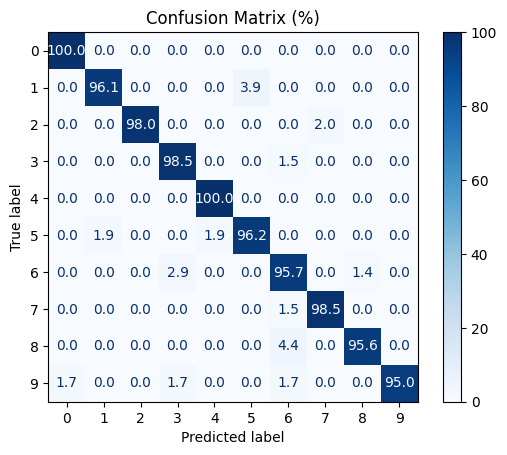

Precision: 0.9748010248923598
Recall: 0.9735028526460751
F1 score: 0.9739669078207273


In [32]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

true_labels = []
pred_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs) 
        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.numpy().tolist())
        pred_labels.extend(preds.cpu().numpy().tolist())

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Normalize the confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create a ConfusionMatrixDisplay object with percentages
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, values_format='.1f')  # Format values to one decimal place
plt.title('Confusion Matrix (%)')

# If you know the class names, you can add them like this:
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=['Class0', 'Class1', ...])

plt.show()

# Print classification report
report = classification_report(true_labels, pred_labels, output_dict=True)

print(f'Precision: {report["macro avg"]["precision"]}')
print(f'Recall: {report["macro avg"]["recall"]}')
print(f'F1 score: {report["macro avg"]["f1-score"]}')

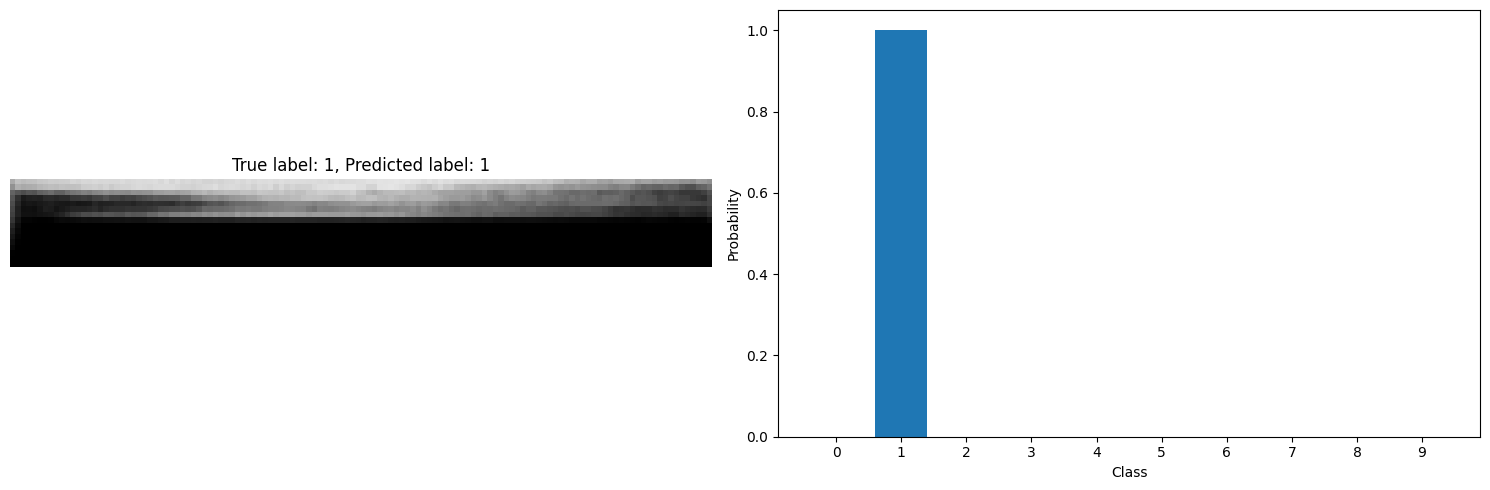

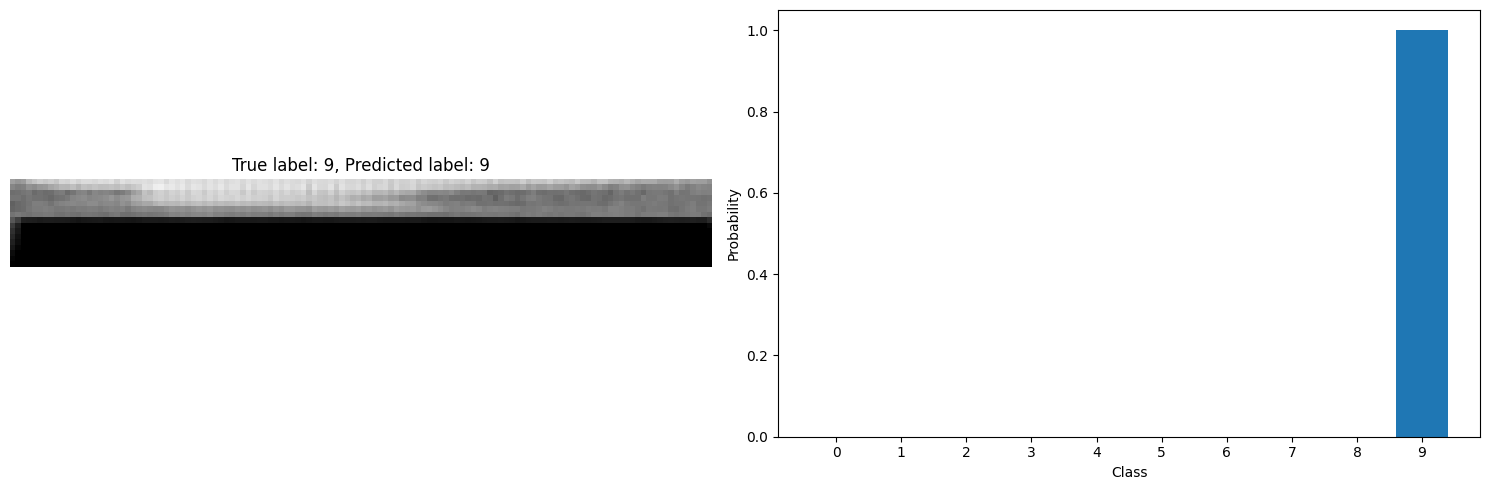

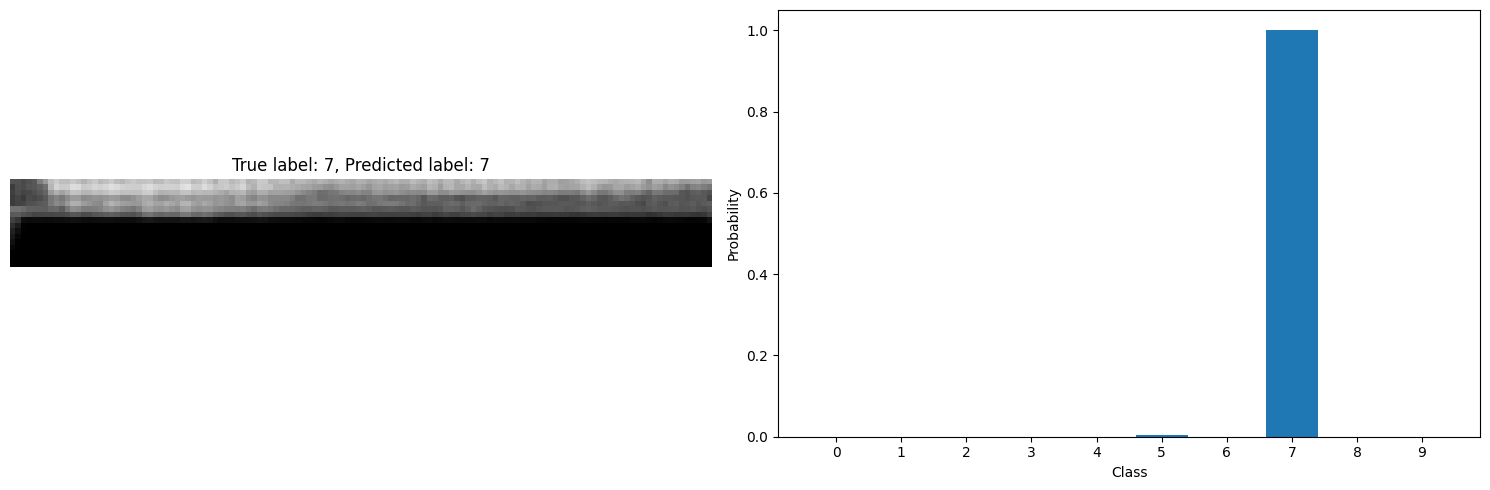

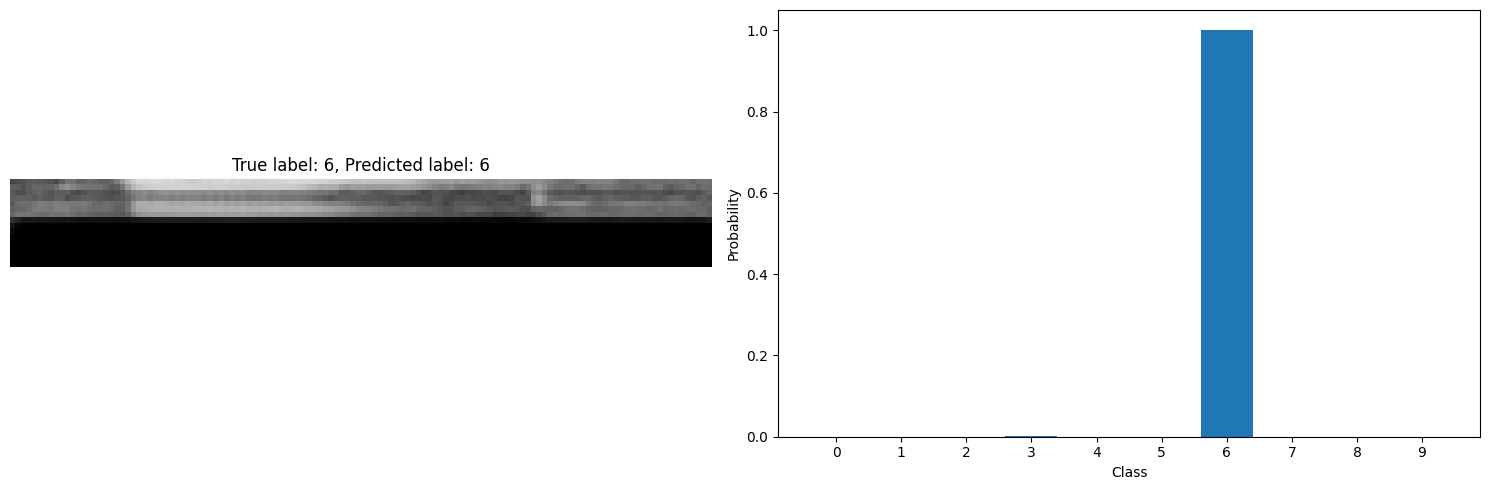

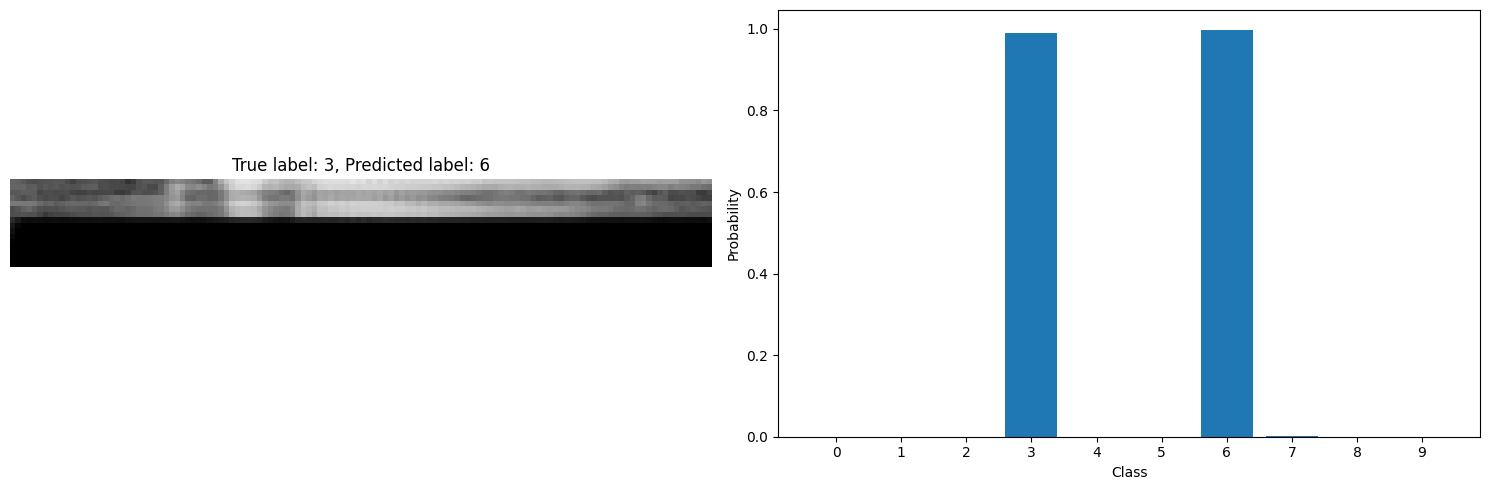

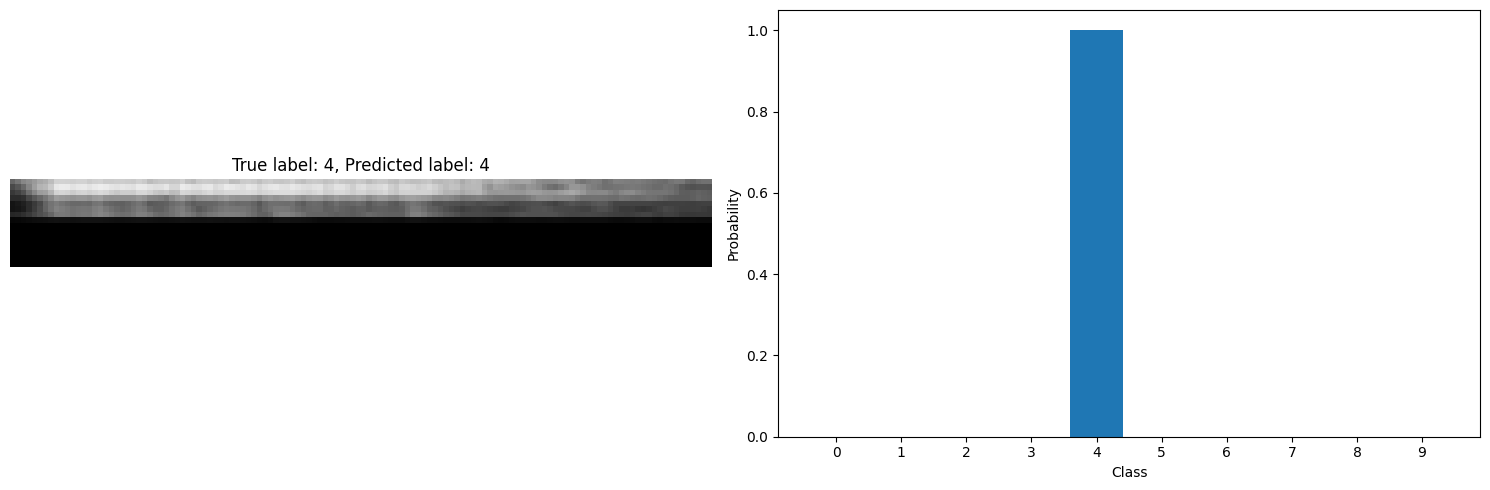

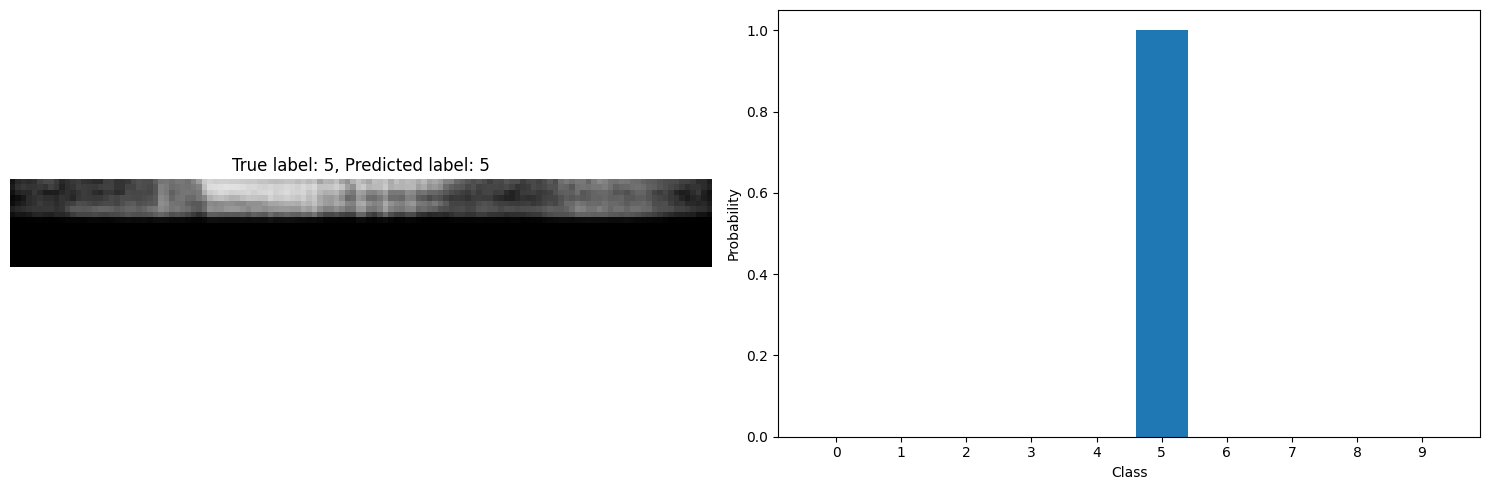

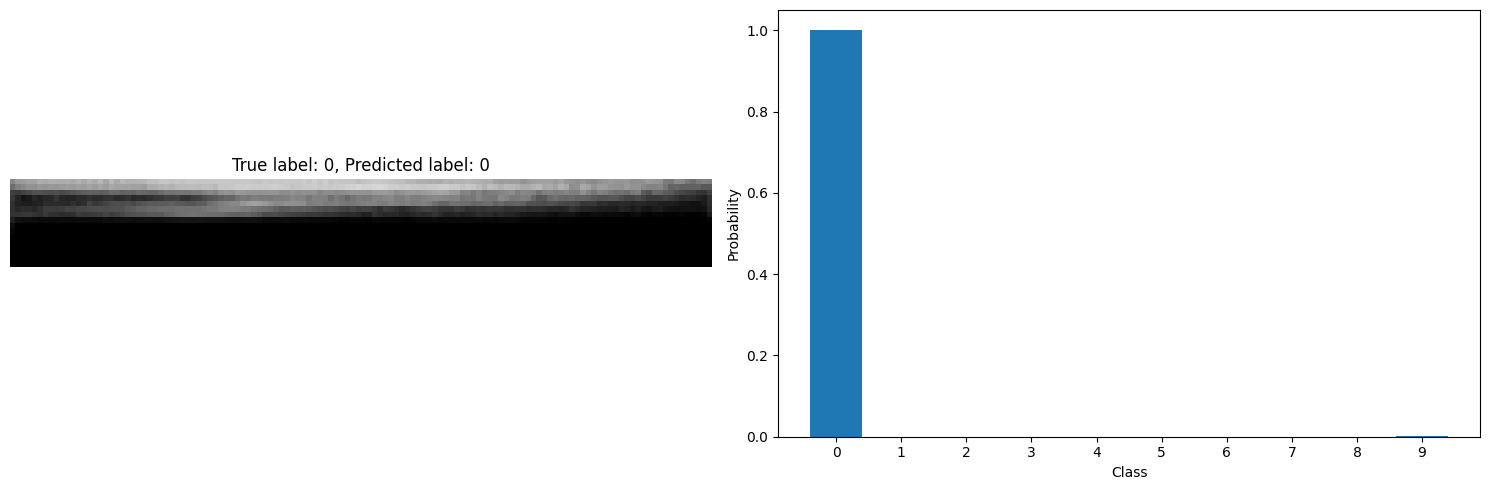

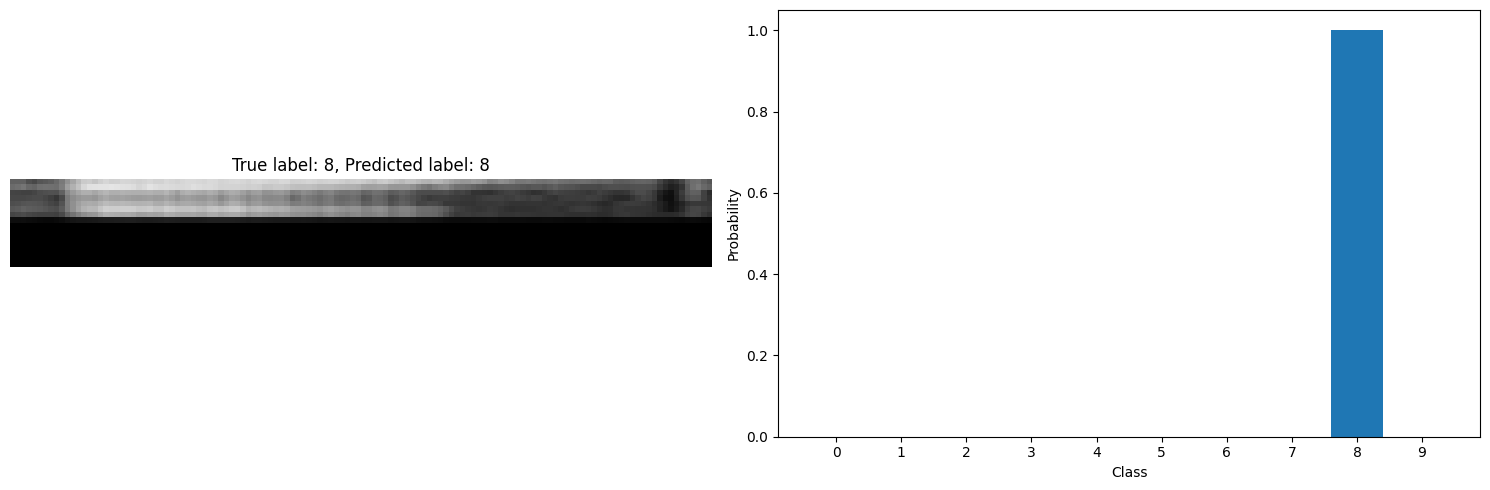

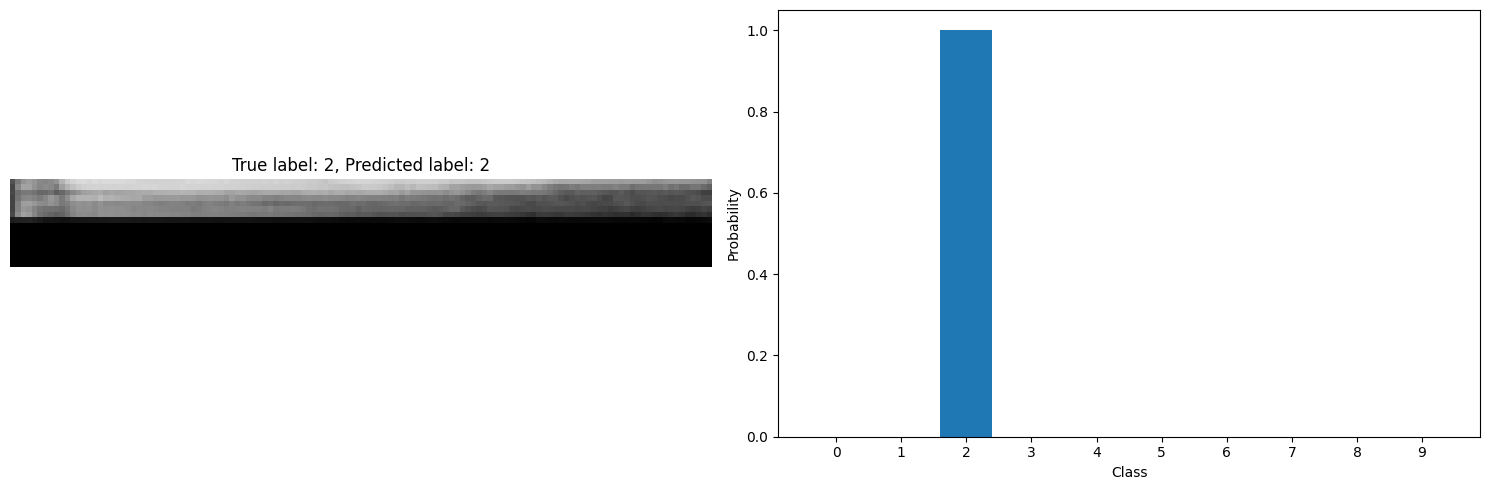

In [30]:
def show_predictions(model, test_dataset, num_images_per_class):
    model.eval()

    # Initialize a dictionary to store the indices of the first occurrence of each class
    class_indices = {}

    # Iterate over the test dataset to find the first occurrence of each class
    for index, (_, label) in enumerate(test_dataset):
        if label not in class_indices:
            class_indices[label] = index

    # Iterate over the class indices and display the specified number of images for each class
    for label, index in class_indices.items():
        for i in range(num_images_per_class):
            if i == 0:
                input_image, _ = test_dataset[index]
            else:
                input_image, _ = test_dataset[index + i]

            with torch.no_grad():
                input_image = input_image.to(device)

                output = model(input_image.unsqueeze(0))
                _, predicted = torch.max(output, 1)
                predicted_label = predicted.item()

            image = input_image.squeeze().cpu().numpy()

            fig, axs = plt.subplots(1, 2, figsize=(15, 5))
            if len(image.shape) == 3:
                sample_image = np.transpose(image, (1, 2, 0))
            elif len(image.shape) == 2:
                sample_image = image

            axs[0].imshow(sample_image,
                          cmap='gray',
                          vmin=0, vmax=1)
            axs[0].set_title("True label: {}, Predicted label: {}".format(label, predicted_label))
            axs[0].axis('off')

            probability = output.cpu()[0].detach().numpy()

            classes = ['0', '1', '2', '3', '4',
                     '5', '6', '7', '8', '9']

            axs[1].bar(classes, probability)
            axs[1].set_xlabel('Class')
            axs[1].set_ylabel('Probability')

            # Rotate the x-axis labels vertically
            #axs[1].tick_params(axis='x', rotation=90)

            plt.tight_layout()
            plt.show()

# Call the function to show predictions
num_images_per_class = 1  # Specify the number of images per class
show_predictions(model, test_dataset, num_images_per_class)